# This notebook is used to predict the buying and selling points from any stock given to the simple logistic regression model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahoo_fin.stock_info import get_data, tickers_sp500, tickers_nasdaq, tickers_other, get_quote_table
from scipy.signal import savgol_filter, argrelmin, argrelmax
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import finta

%matplotlib inline

# Question to be answered or that have been answered

In [ ]:
# Trying to find out when to buy and when to sell?
# Features classify with a 1 when it hits the low
# Features classify with a 1 if it hit the high
# Look at the average volume and if it goes above that classify it as a 1 if not a 0
# Find the cross over between the short rolling ma and the long ma?
# If the MACD Crosses the MACD9 calculate it as a 1 else a 0? Maybe a good feature
# Adding the pct_change as a feature so it does not calculate on solid numbers?

# Calcuate rsi 

In [ ]:
def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

In [2]:
def preproces_data(stock_name, start_date, low_order, high_order, avg_volume):
    stock = get_data(stock_name)
    df = pd.DataFrame(stock).copy()

    data09 = df[df.index > start_date].copy()

    data09['pct_change'] = data09.adjclose.pct_change()
    data09.dropna(inplace=True)
    
    data09['smooth'] = savgol_filter(data09.adjclose, 9, polyorder=2).copy()

    # Making the target variable which will be the low
    target = 'target'
    max_id = 'max_ids'
    data09[target] = 0
    data09[max_id] = 0

    # Finding the minimum for the historical data
    min_ids = argrelmin(data09.smooth.values, order=low_order)[0].tolist()
    max_ids = argrelmax(data09.smooth.values, order=high_order)[0].tolist()

    # Adding if the low occured that day with a 1 and if it did not a 0
    data09[target].iloc[min_ids] = 1
    data09[max_id].iloc[max_ids] = 1
    
    # Adding the average volume
    volume = 'avg_volume'
    data09[volume] = 0

    data09[volume].loc[data09['volume'] > avg_volume] = 1
    
    # Adding the MACD
    short = data09.smooth.rolling(window=12).mean()
    long = data09.smooth.rolling(window=26).mean()
    data09.dropna(inplace=True)

    data09['MACD'] = long - short * -.5
    data09['MACD_9'] = data09.MACD.rolling(window=9).mean()
    data09 = data09.dropna()
    return data09

In [3]:
def calc_rsi(data):
    diff = data.adjclose.diff(1).dropna()

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff

    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]

    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]

    # check pandas documentation for ewm
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=14-1 , min_periods=14).mean()
    down_chg_avg = down_chg.ewm(com=14-1 , min_periods=14).mean()

    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    
    data['RSI'] = rsi
    
    over_70 = 'RSI_70'
    below_30 = 'RSI_30'
    data[over_70] = 0
    data[below_30] = 0

    data[over_70].loc[data['RSI'] >= 70] = 1
    data[below_30].loc[data['RSI'] <= 30] = 1
    
    adjclose = pd.DataFrame()
    adjclose['adjclose'] = data['adjclose']
    
    data.drop(['open', 'low', 'high', 'close', 'volume', 'ticker', 'adjclose'], axis=1, inplace=True)
    
    data.dropna(inplace=True)
    
    return adjclose, data

In [4]:
def predic(df, target, max_id):    
    # Splitting out data to feed into the model
    target_cols = [c for c in df.columns.tolist() if c not in [target]]
    X_target, y_target = df[target_cols].values, df.target.values
    X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_target, y_target, train_size=0.8, random_state=42)
    target_logreg = LogisticRegression(class_weight='balanced', max_iter=200, random_state=42, penalty = 'l2', solver='lbfgs', C=5.0)
    
    # Basic logreg
    target_logreg.fit(X_train_low, y_train_low)
    target_pred = target_logreg.predict(X_test_low)
    target_predictions = target_logreg.predict(X_target)
    
    # Adding our predictions to the data frame
    df['low_logreg_predictions'] = target_predictions
    
    # Splitting data for our max model
    max_cols = [c for c in df.columns.tolist() if c not in [max_id]]
    X_max, y_max = df[max_cols].values, df.max_ids.values
    X_train, X_test, y_train, y_test = train_test_split(X_max, y_max, train_size=0.8, random_state=42)
    max_logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=350, penalty='l2', solver = 'lbfgs', C=5.0)
    
    # Basic log reg for max
    max_logreg.fit(X_train, y_train)
    max_pred = max_logreg.predict(X_test)
    max_predictions = max_logreg.predict(X_max)
    
    # Adding predictions for max back to data frame
    df['max_predictions'] = max_predictions
    
    return target_pred, y_test_low, max_pred, y_test,df

In [40]:
prep_data = preproces_data('ebr', '2002-07-01', 60, 45, 1320000)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [41]:
adjclose, data_rsi = calc_rsi(prep_data)

In [42]:
low_pred,low_real,max_predi,max_real,data = predic(data_rsi, 'target', 'max_ids')

In [43]:
print('Log Reg ROC-AUC Score for test data:', roc_auc_score(low_real, low_pred))
print('Log Reg Accuracy score for test:', accuracy_score(low_real, low_pred))


print('\nLog Reg ROC-AUC Score for test data:', roc_auc_score(max_real, max_predi))
print('Log Reg Accuracy score for test:', accuracy_score(max_real, max_predi))

Log Reg ROC-AUC Score for test data: 0.87677304964539
Log Reg Accuracy score for test: 0.7548500881834215

Log Reg ROC-AUC Score for test data: 0.5864527629233511
Log Reg Accuracy score for test: 0.8342151675485009


In [44]:
data.tail(20)

,pct_change,smooth,target,max_ids,avg_volume,MACD,MACD_9,RSI,RSI_70,RSI_30,low_logreg_predictions,max_predictions
2020-04-02,0.016317,4.303550,0,0,0,7.433435,8.211524,40.399321,0,0,1,0
2020-04-03,-0.052752,4.196970,0,0,0,7.297576,7.996268,38.673276,0,0,1,0
2020-04-06,0.016949,4.268745,0,0,0,7.190082,7.806000,39.520194,0,0,1,0
2020-04-07,0.030952,4.416753,0,0,0,7.101325,7.638702,41.145750,0,0,1,0
2020-04-08,0.080831,4.653420,0,0,0,7.028304,7.491797,45.400635,0,0,1,0
2020-04-09,0.074786,4.918355,0,0,0,6.978968,7.364104,49.344500,0,0,0,0
2020-04-13,-0.007952,5.081169,0,0,0,6.943288,7.254920,48.909679,0,0,0,0
2020-04-14,0.076152,5.161082,0,0,0,6.910521,7.162700,53.134678,0,0,0,0
2020-04-15,-0.055866,5.149481,0,0,0,6.886432,7.085548,49.644250,0,0,0,1
2020-04-16,-0.021696,5.007316,0,0,0,6.862634,7.022126,48.389073,0,0,0,0


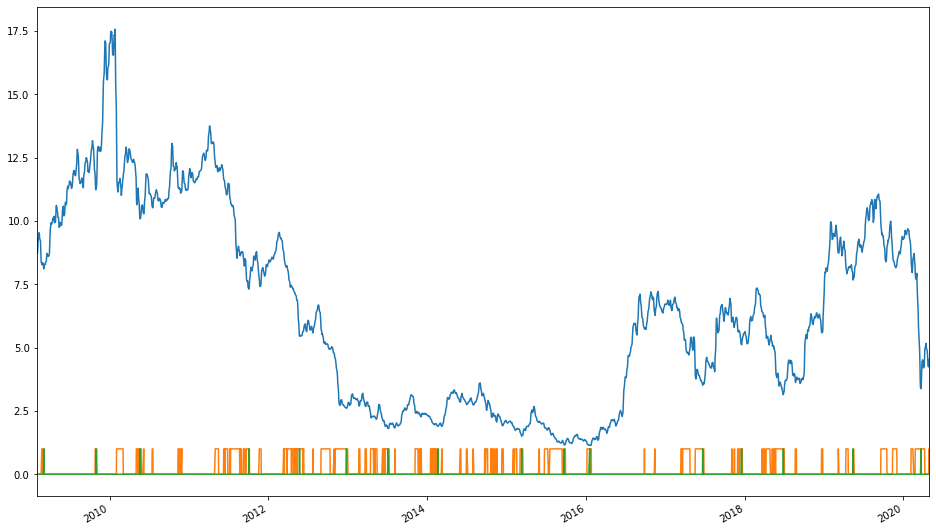

In [45]:
data.smooth.plot(figsize=(16,10))
data.low_logreg_predictions.plot()
data.target.plot();

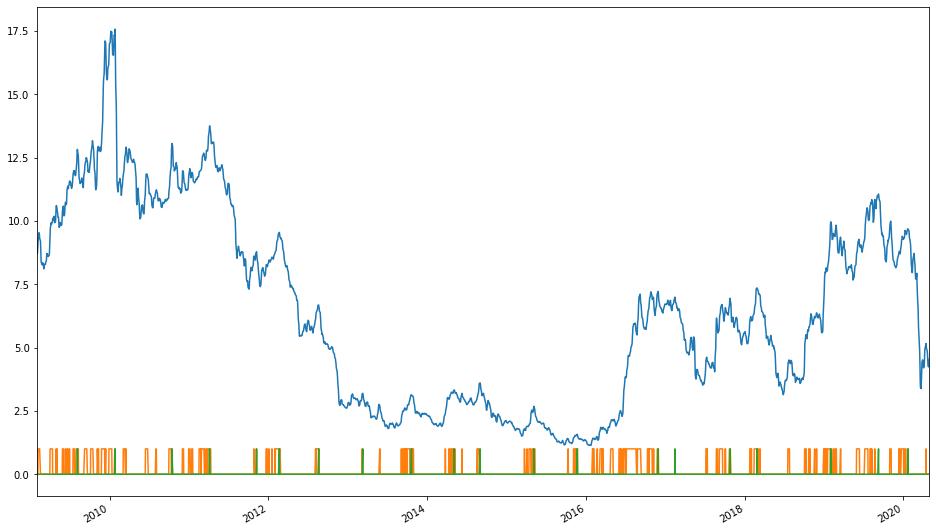

In [46]:
data.smooth.plot(figsize=(16,10))
data.max_predictions.plot()
data.max_ids.plot();

# Testing phase of my project

# Setting the time frame i want so when i visualize the predictions clearly

In [ ]:
# MTNB Stock model
stock = get_data('stng')

df = pd.DataFrame(stock).copy()

start = '2002-01-01'
data09 = df[df.index > start].copy()

# data09['pct_change'] = data09.adjclose.pct_change()

In [ ]:
data09.drop('ticker', axis=1, inplace=True)

# Calculating the RSI

In [ ]:
diff = data09.adjclose.diff(1).dropna()

#this preservers dimensions off diff values
up_chg = 0 * diff
down_chg = 0 * diff

# up change is equal to the positive difference, otherwise equal to zero
up_chg[diff > 0] = diff[ diff>0 ]

# down change is equal to negative deifference, otherwise equal to zero
down_chg[diff < 0] = diff[ diff < 0 ]

# check pandas documentation for ewm
# values are related to exponential decay
# we set com=time_window-1 so we get decay alpha=1/time_window
up_chg_avg   = up_chg.ewm(com=14-1 , min_periods=14).mean()
down_chg_avg = down_chg.ewm(com=14-1 , min_periods=14).mean()

rs = abs(up_chg_avg/down_chg_avg)
rsi = 100 - 100/(1+rs)

In [ ]:
data09['RSI'] = rsi

In [ ]:
over_70 = 'RSI_70'
below_30 = 'RSI_30'
data09[over_70] = 0
data09[below_30] = 0

data09[over_70].loc[data09['RSI'] >= 70] = 1
data09[below_30].loc[data09['RSI'] <= 30] = 1

In [ ]:
data09.tail(35)

In [ ]:
data09 = data09.dropna()

# data09.adjclose.plot()
data09.RSI.plot(figsize=(16,10));

# Finding the low points in our stock and the high points for target variables

In [ ]:
# Gern best order is 45 with .80 average accuracy
# Gern stock from 2002 to present

# ACRX stock best order 40 and 40 for .82 average accuracy
# ACRX stock from 2002 to present

# XXII stock best order 35 and 45 for average .79 accuracy
# XXII stock from 2002 to present

# AT stock order is 30 and 35 for .82 average ac
# AT stock from 2013 to present

# GRPN stock best order is 25 and 20 average accuracu of 80
# GRPN stock from 2013 to present

# AHT stock order is 30 and 45 for average accuracy of .82
# AHT stock from 2002 to present

In [ ]:
# Smoothing to capture a better low
data09['smooth'] = savgol_filter(data09.adjclose, 9, polyorder=2)

# Making the target variable which will be the low
target = 'target'
max_id = 'max_ids'
data09[target] = 0
data09[max_id] = 0

# Finding the minimum for the historical data
min_ids = argrelmin(data09.smooth.values, order=30)[0].tolist()
max_ids = argrelmax(data09.smooth.values, order=35)[0].tolist()

# Adding if the low occured that day with a 1 and if it did not a 0
data09[target].iloc[min_ids] = 1
data09[max_id].iloc[max_ids] = 1

# Getting the average volume for a given stock

In [ ]:
avg_volume = 4380000
volume = 'avg_volume'
data09[volume] = 0

data09[volume].loc[data09['volume'] > avg_volume] = 1

# Making the MACD and the target MACD

In [ ]:
short = data09.smooth.rolling(window=12).mean()
long = data09.smooth.rolling(window=26).mean()
data09.dropna(inplace=True)

data09['MACD'] = long - short * -.5
data09['MACD_9'] = data09.MACD.rolling(window=9).mean()

# Droping unwanted information and unwanted columns

In [ ]:
data09 = data09.dropna()

In [ ]:
adjclose = pd.DataFrame()

adjclose['adjclose'] = data09['adjclose']

In [ ]:
data09.drop(['open', 'low', 'high', 'close', 'volume', 'ticker', 'adjclose'], axis=1, inplace=True)

# Getting the features i need to train my model for the target low

In [ ]:
target_cols = [c for c in data09.columns.tolist() if c not in [target]]

X_target, y_target = data09[target_cols].values, data09.target.values

X_train, X_test, y_train, y_test = train_test_split(X_target, y_target, train_size=0.8, random_state=42)

target_logreg = LogisticRegression(class_weight='balanced', max_iter=100, random_state=42, penalty = 'l2', solver='lbfgs', C=5.0)

# Training my model on training data

In [ ]:
# Basic logreg
target_logreg.fit(X_train, y_train)
target_pred = target_logreg.predict(X_test)
target_predictions = target_logreg.predict(X_target)

# Analyzing model score

In [ ]:
data09['low_logreg_predictions'] = target_predictions

print('Log Reg ROC-AUC Score for test data:', roc_auc_score(y_test, target_pred))
print('Log Reg Accuracy score for test:', accuracy_score(y_test, target_pred))

# Predicting the highs using logistic regression

In [ ]:
max_cols = [c for c in data09.columns.tolist() if c not in [max_id]]

X_max, y_max = data09[max_cols].values, data09.max_ids.values

X_train, X_test, y_train, y_test = train_test_split(X_max, y_max, train_size=0.8, random_state=42)

max_logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=200, penalty='l2', solver = 'lbfgs', C=5.0)

In [ ]:
max_logreg.fit(X_train, y_train)

max_pred = max_logreg.predict(X_test)

max_predictions = max_logreg.predict(X_max)
# Probability max_logreg.predict_proba(X_max)[:,-1]

In [ ]:
data09['max_predictions'] = max_predictions

print('ROC-AUC Score for test data:', roc_auc_score(y_test, max_pred))
print('Accuracy score for test:', accuracy_score(y_test, max_pred))

# Visualizing my graph and predictions

In [ ]:
plt.figure(figsize=(16,10))
data09.smooth.plot()
# df.lma.plot()
# df.sma.plot()
# df.MACD.plot()
# df.MACD_9.plot()
data09.low_logreg_predictions.plot(color='green')
data09.target.plot(color='r');
# data09.max_predictions.plot(color='red')
# data09.max_ids.plot(color='green');